<a href="https://colab.research.google.com/github/ShubhrajitS/Track/blob/main/behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ShubhrajitS/Track



Cloning into 'Track'...
remote: Enumerating objects: 22619, done.
remote: Total 22619 (delta 0), reused 0 (delta 0), pack-reused 22619
Receiving objects: 100% (22619/22619), 286.72 MiB | 34.61 MiB/s, done.
Checking out files: 100% (22616/22616), done.


In [ ]:
!ls Track


driving_log.csv  IMG  README.md


In [ ]:
!pip3 install imgaug

In [ ]:
import os
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import ntpath
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa


In [ ]:
datadir = 'Track'
columns = ['center', 'left', 'right', 'steering','throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\sinha\Downloads\data\IMG\center_2021_07_25_10_14_13_322.jpg  ...  0.000078
1  C:\Users\sinha\Downloads\data\IMG\center_2021_07_25_10_14_13_424.jpg  ...  0.000078
2  C:\Users\sinha\Downloads\data\IMG\center_2021_07_25_10_14_13_525.jpg  ...  0.000078
3  C:\Users\sinha\Downloads\data\IMG\center_2021_07_25_10_14_13_627.jpg  ...  0.000080
4  C:\Users\sinha\Downloads\data\IMG\center_2021_07_25_10_14_13_729.jpg  ...  0.000080

[5 rows x 7 columns]

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] =  data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


center  ...     speed
0  center_2021_07_25_10_14_13_322.jpg  ...  0.000078
1  center_2021_07_25_10_14_13_424.jpg  ...  0.000078
2  center_2021_07_25_10_14_13_525.jpg  ...  0.000078
3  center_2021_07_25_10_14_13_627.jpg  ...  0.000080
4  center_2021_07_25_10_14_13_729.jpg  ...  0.000080

[5 rows x 7 columns]

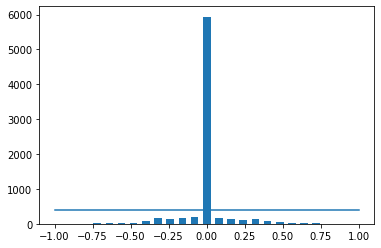

In [ ]:
num_bins =25
samples_per_bin = 400
hist, bins =np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:])*0.5
# print(bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))


total 7538
removed 5538
remaining 2000


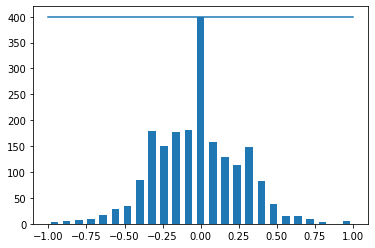

In [ ]:
print('total', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<= bins[j+1]:
       list_.append(i)
  list_ = shuffle(list_)
  list_ =list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining', len(data))


hist, _ =  np.histogram(data['steering'], (num_bins))

plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))


In [ ]:
print(data.iloc[1])

center      center_2021_07_25_10_14_14_442.jpg
left        left_2021_07_25_10_14_14_442.jpg  
right       right_2021_07_25_10_14_14_442.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       8.03404e-05                       
Name: 11, dtype: object


In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0],indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings= load_img_steering(datadir + '/IMG', data)


center      center_2021_07_25_10_14_14_442.jpg
left        left_2021_07_25_10_14_14_442.jpg  
right       right_2021_07_25_10_14_14_442.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       8.03404e-05                       
Name: 11, dtype: object


In [ ]:
print(image_paths)

['Track/IMG/center_2021_07_25_10_14_13_729.jpg'
 'Track/IMG/center_2021_07_25_10_14_14_442.jpg'
 'Track/IMG/center_2021_07_25_10_14_15_860.jpg' ...
 'Track/IMG/center_2021_07_25_10_27_16_338.jpg'
 'Track/IMG/center_2021_07_25_10_27_18_613.jpg'
 'Track/IMG/center_2021_07_25_10_36_56_121.jpg']


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state =6)

print('Training samples:{}\nValid Samples): {}'.format(len(X_train), len(X_valid)))

print((X_train))
print(y_train)

Training samples:1600
Valid Samples): 400
['Track/IMG/center_2021_07_25_10_15_22_702.jpg'
 'Track/IMG/center_2021_07_25_10_21_35_793.jpg'
 'Track/IMG/center_2021_07_25_10_19_18_133.jpg' ...
 'Track/IMG/center_2021_07_25_10_15_43_555.jpg'
 'Track/IMG/center_2021_07_25_10_18_52_677.jpg'
 'Track/IMG/center_2021_07_25_10_20_03_789.jpg']
[ 0.         0.        -0.2013171 ... -0.2284167  0.        -0.1524618]


Text(0.5, 1.0, 'Validation Set')

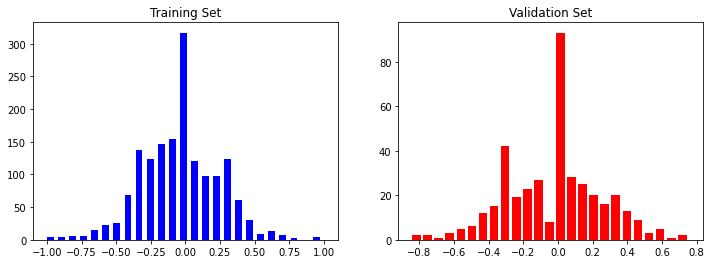

In [ ]:
fig, axes =  plt.subplots(1,2, figsize = (12,4))
axes[0].hist(y_train, bins=num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training Set')

axes[1].hist(y_valid, bins=num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation Set')

In [ ]:
def zoom(image):
  zoom=iaa.Affine(scale=(1, 1.3))
  image= zoom.augment_image(image)
  return image


In [ ]:
def pan(image):
  pan= iaa.Affine(translate_percent = {"x":(-0.1,0.1), "y": (-0.1,0.1)})
  image = pan.augment_image(image)
  return image


In [ ]:
image = image_paths[random.randint(0,1000)]
print(type(image))

<class 'numpy.str_'>


Text(0.5, 1.0, 'Zoom Image')

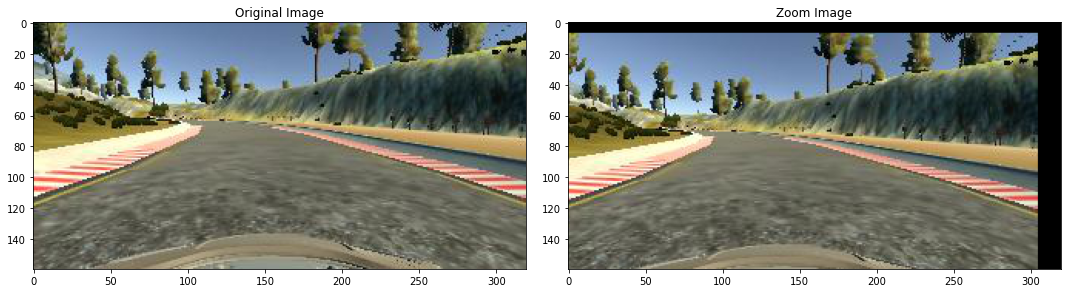

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs =  plt.subplots(1, 2,figsize =(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Zoom Image')

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'bright Image')

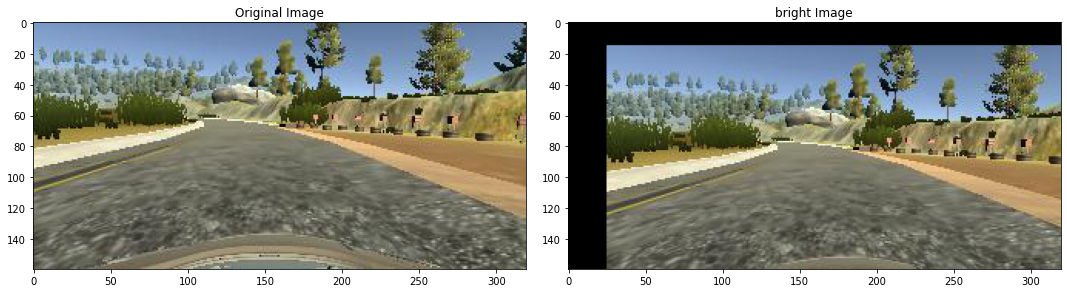

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
bright_image = pan(original_image)

fig, axs =  plt.subplots(1, 2,figsize =(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(bright_image)
axs[1].set_title('bright Image')

In [ ]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle= -steering_angle
  return image, steering_angle



Text(0.5, 1.0, 'flip Image')

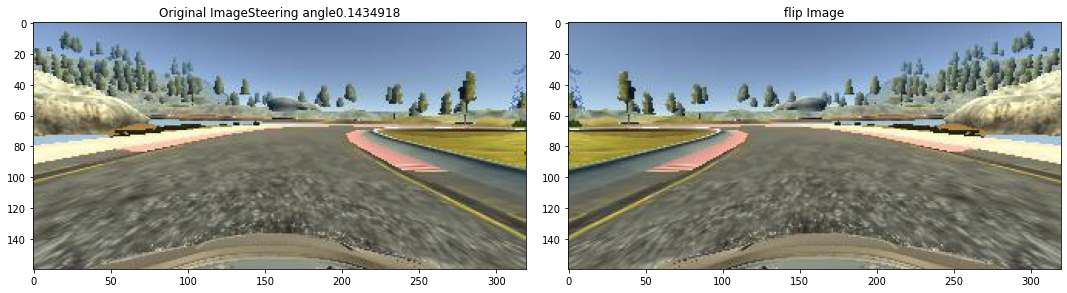

In [ ]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle =  steerings[random_index]



original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image,steering_angle)

fig, axs =  plt.subplots(1, 2,figsize =(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image'+'Steering angle'+ str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('flip Image')

In [ ]:
def random_argument(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand()<0.5:
    image = pan(image)
  if np.random.rand()<0.5:
      image = zoom(image)
  if np.random.rand()<0.5:
      image = img_random_brightness(image)
  if np.random.rand()<0.5:
      image, steering = img_random_flip(image, steering_angle)
  return image, steering_angle



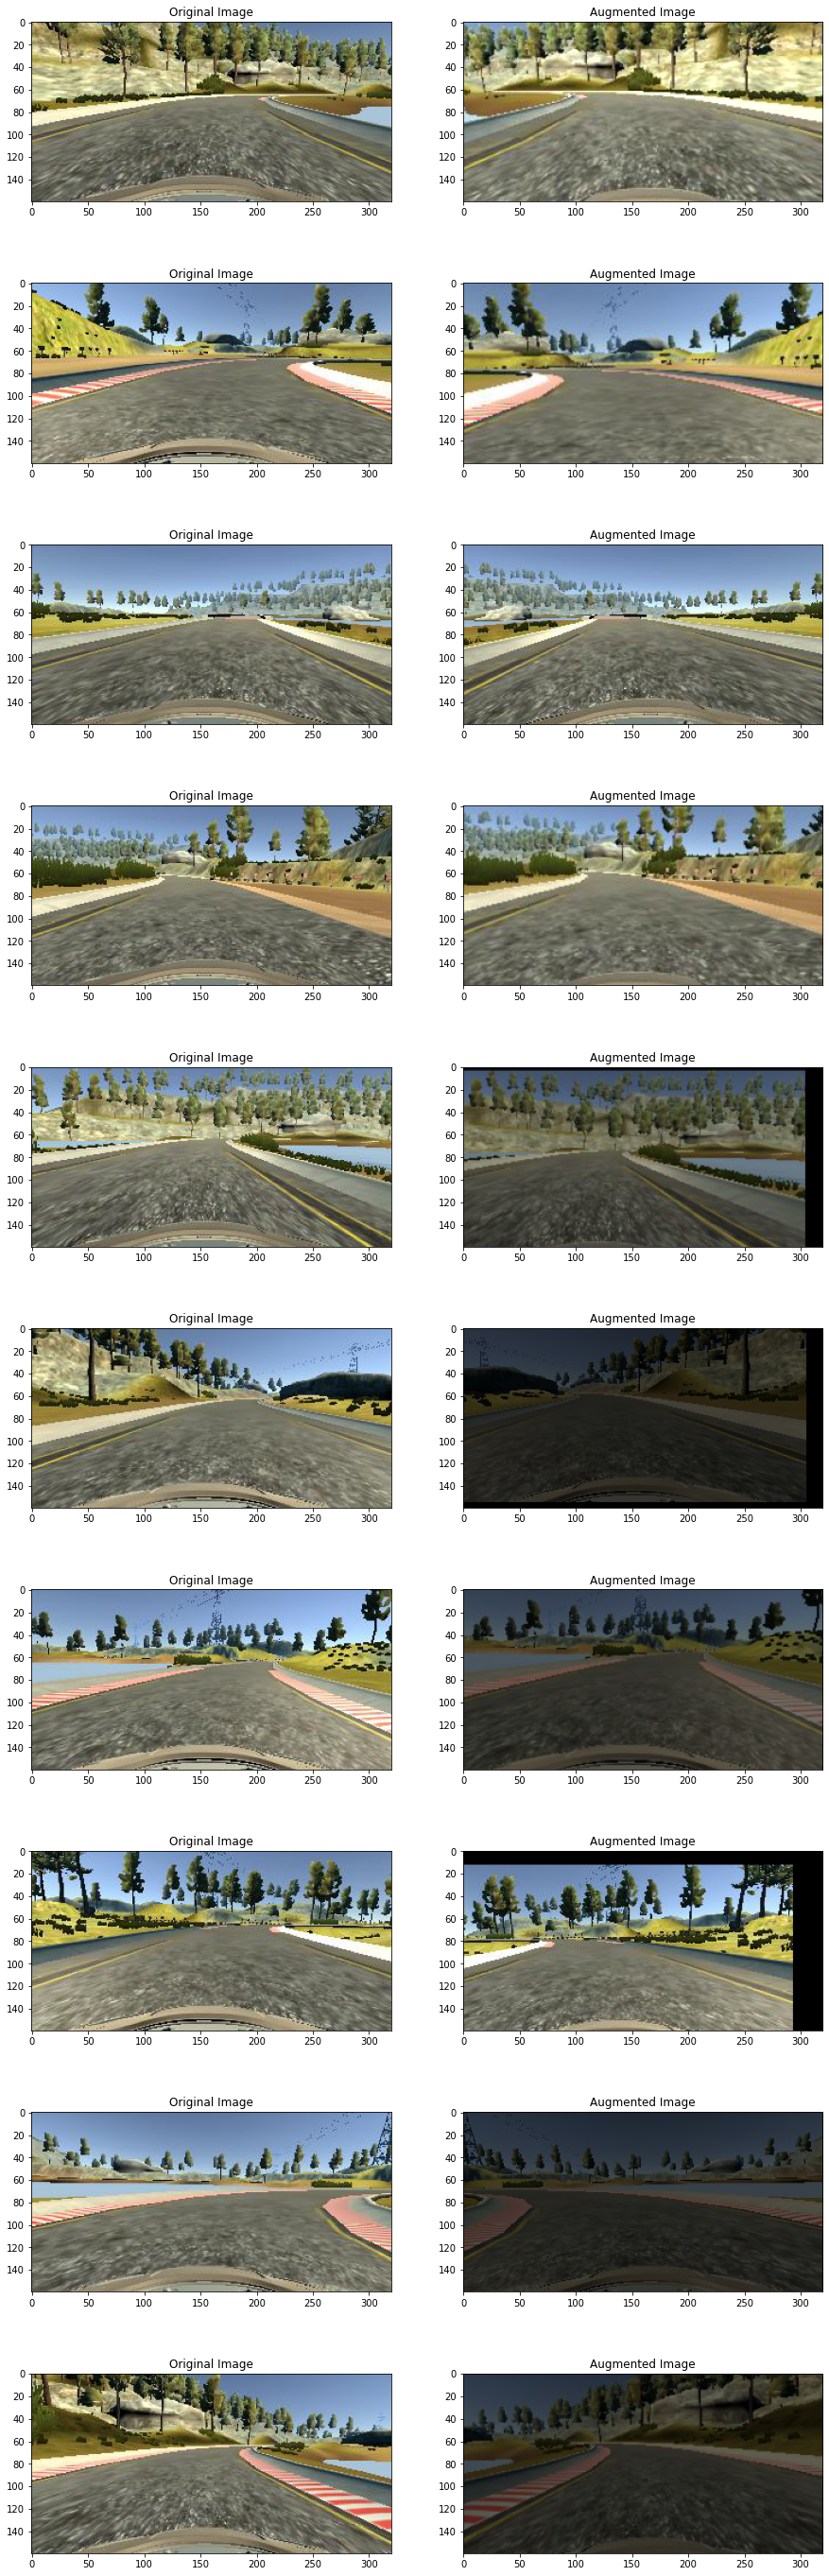

In [ ]:
ncol =2
nrow =10

fig, axs = plt.subplots(nrow,ncol, figsize=(15,50))
fig.tight_layout

for i in range(10):
  randnum = random.randint(0,len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_argument(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [ ]:
def img_preprocess(img):
  # img =  mpimg.imread(img)
  img = img[60:135,:,:]
  img =  cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img


In [ ]:
# image = image_paths[100]
# original_image = mpimg.imread(image)
# preprocessed_image = img_preprocess(image)

# fig, axs = plt.subplots(1,2, figsize = (15,10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Original Image')

# axs[1].imshow(preprocessed_image)
# axs[1].set_title('Preprocessed Image')

In [ ]:
# def batch_generator(image_paths, steering_ang, batch_size, istraining):
#   while True:
#     batch_img = []
#     batch_steering = []

#     for i in range(batch_size):
#       random_index = random.randint(0,len(image_paths)-1)

#       if istraining:
#         random_argument(image_paths[random_index], steering_ang[random_index])
#       else:
#         im = mpimg.imread(image_paths[random_index])
#         steering = steering_ang[random_index]

#       img_preprocess(im)
#       batch_img.append(im)
#       batch_steering.append(steering)
#     yield (np.asarray(batch_img),np.asarray(batch_steering))



def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_argument(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))


Text(0.5, 1.0, 'Validation Image')

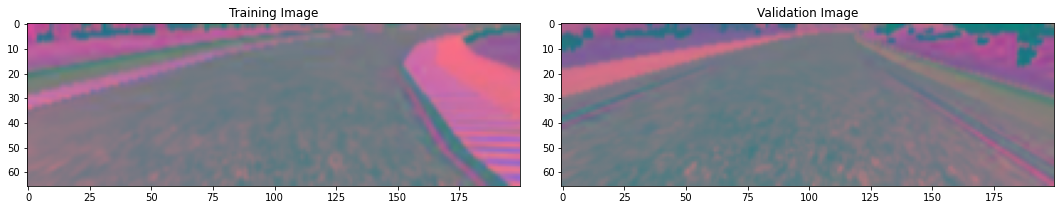

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')



In [ ]:
# X_train =  np.array(list(map(img_preprocess, X_train)))
# X_valid =  np.array(list(map(img_preprocess, X_valid)))

In [ ]:
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])

# plt.axis('off')
# print(X_train.shape)

In [ ]:
# def nvidia_model():
#   model = Sequential()


#   model.add(Convolution2D(24,5,5,strides = (2,2),input_shape = (66,200,3), activation = 'relu'))
#   model.add(Convolution2D(36,5,5,strides = (2,2), activation = 'relu'))
#   model.add(Convolution2D(48,5,5,strides = (2,2),activation = 'relu'))
#   model.add(Convolution2D(64,3,3, activation = 'relu'))
#   model.add(Convolution2D(64,3,3, activation = 'relu'))

#   model.add(Dropout(0.5))


#   model.add(Flatten())
#   model.add(Dense(100, activation = 'relu'))
#   model.add(Dropout(0.5))

#   model.add(Dense(50,  activation = 'relu'))
#   model.add(Dense(10,  activation = 'relu'))
#   model.add(Dense(1))

#   optimizer = Adam(lr=0.001)
#   model.compile(loss = 'mse', optimizer= optimizer)
#   return model

# def nvidia_model():
#   model = Sequential()
#   model.add(Convolution2D(24, 5, 5, strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
#   model.add(Convolution2D(36, 5, 5, strides=(2, 2), activation='elu'))
#   model.add(Convolution2D(48, 5, 5, strides=(2, 2), activation='elu'))
#   model.add(Convolution2D(64, 3, 3, activation='elu'))

#   model.add(Convolution2D(64, 3, 3, activation='elu'))
# #   model.add(Dropout(0.5))


#   model.add(Flatten())

#   model.add(Dense(100, activation = 'elu'))
# #   model.add(Dropout(0.5))

#   model.add(Dense(50, activation = 'elu'))
# #   model.add(Dropout(0.5))

#   model.add(Dense(10, activation = 'elu'))
# #   model.add(Dropout(0.5))

#   model.add(Dense(1))

#   optimizer = Adam(lr=1e-3)
#   model.compile(loss='mse', optimizer=optimizer)
#   return model

def nvidia_model():

    model = Sequential()

    model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))

    model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
    # model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    # model.add(Dropout(0.5))


    model.add(Dense(50, activation='elu'))
    # model.add(Dropout(0.5))
    model.add(Dense(10, activation ='elu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))


    optimizer= Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)

    return model






In [ ]:
model = nvidia_model()
print(model.summary())



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 434s 1s/step - loss: 0.0781 - val_loss: 0.0633
Epoch 2/10
300/300 [==============================] - 445s 1s/step - loss: 0.0713 - val_loss: 0.0539
Epoch 3/10
300/300 [==============================] - 435s 1s/step - loss: 0.0683 - val_loss: 0.0499
Epoch 4/10
300/300 [==============================] - 422s 1s/step - loss: 0.0665 - val_loss: 0.0466
Epoch 5/10
300/300 [==============================] - 422s 1s/step - loss: 0.0654 - val_loss: 0.0426
Epoch 6/10
300/300 [==============================] - 431s 1s/step - loss: 0.0642 - val_loss: 0.0412
Epoch 7/10
300/300 [==============================] - 420s 1s/step - loss: 0.0606 - val_loss: 0.0389
Epoch 8/10
300/300 [==============================] - 430s 1s/step - loss: 0.0599 - val_loss: 0.0411
Epoch 9/10
300/300 [==============================] - 424s 1s/step - loss: 0.0583 - val_loss: 0.0390
Epoch 10/10
300/300 [==============================] - 426s 1s/step - loss: 0.0565 - val_lo

Text(0.5, 0, 'Epochs')

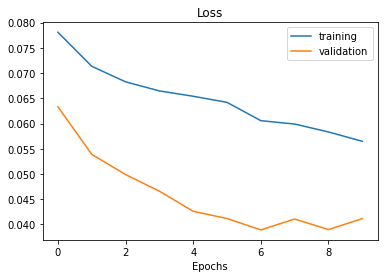

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [ ]:
model.save('model.h5')


In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>